# Experiment 01
## Testing with Unicode (◯←▢) encoding of questionnaire
### Richardson et. al (2002) Experiment 01 with Language Models instead of Humans:

The subjects were presented with a single page,
containing a list of the verbs and four pictures, labelled A to
D. Each one contained a circle and a square aligned along a
vertical or horizontal axis, connected by an arrow pointing
up, down, left or right. Since we didn't expect any
interesting item variation between left or right placement of
the circle or square, the horizontal schemas differed only in
the direction of the arrow.
For each sentence, subjects were asked to select one of
the four sparse images that best depicted the event described
by the sentence (Figure 1)
The items were randomised in three different orders, and
crossed with two different orderings of the images. The six
lists were then distributed randomly to subjects.

### Step 01: Creating a prompt that is as close to the paper as possible

In [1]:
import random
random.seed(1337)


def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value

with open("../../data/richardson_actions.txt", "r") as d_in:
    lines = [line.split() for line in d_in.readlines()]

output = []
for entry in lines:
    new_entry = [convert_to_float(item) for item in entry]
    
    if isinstance(new_entry[1],str):
        new_entry[0] = " ".join(new_entry[:2])
        del new_entry[1]
    output.append(new_entry)

richardson_data = dict()
for elem in output:
    richardson_data[elem[0]] = [i for i in elem[1:]]

# richardson_data : ["C:◯↑▢", "D:◯↓▢","B:◯←▢ ","A:◯→▢"]

# Randomizing Richardson's data
action_words = list(richardson_data.keys())
random.shuffle(action_words)

#count=1
#for line in action_words:
#    if line != 0:
#        print(str(count)+". ◯ "+line+" ▢ \\")
#        count+=1

In [5]:
paper_prompt = "You are asked to select one of the four images that best depicts the event described by the following sentences. \
Image A: \
◯→▢ \
\
Image B: \
◯←▢ \
 \
Image C: \
◯ \
↑ \
▢ \
\
Image D: \
◯ \
↓ \
▢ \
\
Sentences: \
1. ◯ hunted ▢ \
2. ◯ showed ▢ \
3. ◯ succeeded ▢ \
4. ◯ pointed at ▢ \
5. ◯ pushed ▢ \
6. ◯ hoped ▢ \
7. ◯ walked ▢ \
8. ◯ gave to ▢ \
9. ◯ respected ▢ \
10. ◯ smashed ▢ \
11. ◯ argued with ▢ \
12. ◯ sank ▢ \
13. ◯ rested ▢ \
14. ◯ offended ▢ \
15. ◯ pulled ▢ \
16. ◯ perched ▢ \
17. ◯ regretted ▢ \
18. ◯ bombed ▢ \
19. ◯ obeyed ▢ \
20. ◯ lifted ▢ \
21. ◯ flew ▢ \
22. ◯ impacted ▢ \
23. ◯ wanted ▢ \
24. ◯ increased ▢ \
25. ◯ warned ▢ \
26. ◯ floated ▢ \
27. ◯ tempted ▢ \
28. ◯ rushed ▢ \
29. ◯ owned ▢ \
\
For sentence 1) choosing from [A,B,C,D] best image is "


### Step 02: Test model with this `paper prompt`

#### Function to evaluate against Richardson's findings

In [1]:
import torch
from transformers import GPT2Tokenizer, OPTForCausalLM, AutoTokenizer, AutoModelForCausalLM
from transformers import GPTNeoXForCausalLM, GPTNeoXTokenizerFast, GPTNeoForCausalLM, GPT2Tokenizer
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import json
from scipy import stats
from collections import Counter
import subprocess

with open("../../hf.key", "r") as f_in:
    hf_key = f_in.readline().strip()
subprocess.run(["huggingface-cli", "login", "--token", hf_key])

server_model_path = "/mounts/data/corp/huggingface/"
model_type = "meta-llama"
model_name = "Llama-2-70b-hf"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /mounts/data/corp/huggingface/token
Login successful


In [2]:
#tokenizer = GPTNeoXTokenizerFast.from_pretrained(model_prefix+"-"+model_size, device_map="auto")
#model = GPTNeoXForCausalLM.from_pretrained(model_prefix+"-"+model_size, device_map="auto")

#tokenizer = GPT2Tokenizer.from_pretrained(model_prefix+"-"+model_size, device_map="auto")
#model = OPTForCausalLM.from_pretrained(model_prefix+"-"+model_size, device_map="auto")

#tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-13b-hf", use_auth_token=True, device_map="auto")
#model = AutoModelForCausalLM.from_pretrained(server_model_path+"llama/llama-13b", use_auth_token=True, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_type+"/"+model_name, use_auth_token=True, device_map="auto")
model = AutoModelForCausalLM.from_pretrained(server_model_path+model_type+"/"+model_name, use_auth_token=True, device_map="auto")

/mounts/work/pwicke/miniconda3/envs/schemas/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/mounts/work/pwicke/miniconda3/envs/schemas/lib/python3.8/site-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
# Step 1: Tokenize the prompt
input_ids = tokenizer.encode(paper_prompt, return_tensors="pt")

# Step 2: Generate the model input
max_length = input_ids.size(1)  + 20 # Adjust '20' as needed to control the maximum length of the generated answer.
output = model.generate(input_ids, max_length=max_length, num_return_sequences=1)

# Step 3: Decode the generated output to get the answer
generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)


/mounts/work/pwicke/miniconda3/envs/schemas/lib/python3.8/site-packages/transformers/generation/utils.py:1468: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


RuntimeError: You must initialize the accelerate state by calling either `PartialState()` or `Accelerator()` before using the logging utility.

In [9]:
print("Generated answer:\n\n", generated_answer[len(paper_prompt):])

Generated answer:

 ◯→▢. For sentence 2) choosing from [A,B,


### Step 03: Testing different prompts that are maximally friendly for the LLM

In [10]:
prompt_B = "Select the image that best represents the event described by the sentence: "+action_word+"\n[◯→▢]\n\n[◯←▢]\n\n[◯\n↑\n▢]\n\n[◯\n↓\n▢]\n\nThe best representation is [◯"
#prompt_C = "Choose the best image for the word:\nUP: ↑ \nDOWN: ↓ \nLEFT: → \nRIGHT: ← \n"+action_word.upper()+": "
#prompt_D = "Choosing from UP, DOWN, LEFT and RIGHT, the word \'"+action_word.upper()+"\' is best respresented by the word "
#prompt_B = "Of these four: A: ◯→▢ B: ◯←▢ C: ◯ ↑ ▢ D: ◯ ↓ ▢ Which one best describes \"◯ "+action_word+" ▢\" ?"

ACTION: walked
Generated answer:

 →▢].

### 
ACTION: perched
Generated answer:

 
↓
▢].

Select
ACTION: respected
Generated answer:

 
↓
▢].

Select
ACTION: fled
Generated answer:

 ←▢].

### 
ACTION: pulled
Generated answer:

 ←▢].

### 
ACTION: wanted
Generated answer:

 →▢].

Select the image
ACTION: pushed
Generated answer:

 ←▢].

Select the image
ACTION: argued with
Generated answer:

 ←▢].

### 
ACTION: obeyed
Generated answer:

 ←▢].

### 
ACTION: showed


KeyboardInterrupt: 

### Step 03: Test pipline with logprobs and `friendly prompt`

In [11]:
from sidemethods import logprobs_from_prompt, proc, proc_lower, prob_of_ending, calculate_accuracy, calculate_accuracies, store_accuracies

In [12]:
def get_action_prompt(action):
    return "Select the image that best represents the event described by the sentence: "+action+"\n[◯→▢]\n\n[◯←▢]\n\n[◯\n↑\n▢]\n\n[◯\n↓\n▢]\n\nThe best representation is [◯"
    
def get_test_action(country):
    return country+"'s captitol is "

In [2]:
richardson_data

{'fled': [7.2, 4.2, 80.8, 7.8],
 'pointed at': [7.2, 3.6, 0.0, 89.2],
 'pulled': [6.0, 5.4, 75.4, 13.2],
 'pushed': [7.2, 3.6, 1.2, 88.0],
 'walked': [9.0, 3.6, 24.0, 62.9],
 'hunted': [9.6, 20.4, 1.8, 68.3],
 'impacted': [7.2, 37.1, 3.0, 52.7],
 'perched': [12.0, 76.0, 6.6, 5.4],
 'showed': [15.0, 9.0, 10.2, 65.9],
 'smashed': [3.6, 66.5, 1.2, 28.7],
 'bombed': [4.8, 86.8, 1.8, 6.6],
 'flew': [37.7, 44.3, 15.0, 3.0],
 'floated': [32.9, 56.3, 7.8, 3.0],
 'lifted': [87.4, 9.6, 2.4, 0.6],
 'sank': [22.2, 71.9, 4.2, 1.8],
 'argued with': [11.4, 13.8, 12.6, 62.3],
 'gave to': [8.4, 9.6, 1.2, 80.8],
 'offended': [9.0, 31.7, 24.6, 34.7],
 'rushed': [10.2, 10.8, 23.4, 55.1],
 'warned': [10.8, 22.2, 6.0, 61.1],
 'owned': [5.4, 55.7, 18.6, 20.4],
 'regretted': [19.8, 24.0, 41.3, 15.0],
 'rested': [14.4, 36.5, 40.1, 9.0],
 'tempted': [16.8, 11.4, 45.5, 26.3],
 'wanted': [15.6, 7.8, 15.6, 61.1],
 'hoped': [45.5, 15.6, 7.2, 31.7],
 'increased': [73.7, 7.2, 9.6, 9.0],
 'obeyed': [22.8, 4.2, 64.7, 8

In [14]:
friendly_prompt_choices = dict()

#action_words= ["Germany", "Australia", "Japan", "Israel", "France"]

for action_word in tqdm(action_words):
    #print(action_word)
    if action_word == 0:
        continue
    
    start = get_action_prompt(action_word)
    #start = get_test_action(action_word)
    
    
    answers = {0:"→", 1:"←", 2:"↑", 3:"↓"}
    #answers = {0: "Berlin", 1:"Paris", 2:"Canberra", 3:"Tokyo"}

    #start = "nazis are known to be on the political "
    #answers = {0:"UP", 1:"DOWN", 2:"LEFT", 3:"RIGHT"}

    res_ends = []
    for j, end in answers.items():
        input_prompt = proc(start) + ' ' + proc(end)
        logprobs = logprobs_from_prompt(input_prompt, tokenizer, model)
        res = {"tokens": [x for x,y in logprobs],"token_logprobs": [y for x,y in logprobs]}
        res_ends.append(res)

    choosen_answer = (-9999, "")
    
    choice_distribution = []
    for i, answer in answers.items():
        choice_val = prob_of_ending(res_ends[i]['token_logprobs'], res_ends[i]['tokens'])
        if choice_val > choosen_answer[0]:
            choosen_answer = choice_val, answer
        choice_distribution.append(choice_val)
    
    # Richardson has table columns and image sequences mixed up, we align it here
    friendly_prompt_choices[action_word] = []
    friendly_prompt_choices[action_word].append(choice_distribution[2])
    friendly_prompt_choices[action_word].append(choice_distribution[3])
    friendly_prompt_choices[action_word].append(choice_distribution[1])
    friendly_prompt_choices[action_word].append(choice_distribution[0])

    #print("Choice: ", choosen_answer[1])
    #print()




100%|██████████| 31/31 [01:50<00:00,  3.56s/it]


In [15]:
for k, v in friendly_prompt_choices.items():
    print(k, [round(x,2) for x in v])

walked [-0.78, -1.41, -1.64, -2.11]
perched [-0.72, -1.38, -1.78, -2.32]
respected [-0.78, -1.41, -1.71, -2.28]
fled [-0.8, -1.36, -1.6, -2.13]
pulled [-0.8, -1.4, -1.65, -2.17]
wanted [-0.81, -1.41, -1.67, -2.15]
pushed [-0.83, -1.42, -1.63, -2.07]
argued with [-0.78, -1.31, -1.64, -2.33]
obeyed [-0.79, -1.31, -1.69, -2.21]
showed [-0.79, -1.39, -1.67, -2.22]
sank [-0.81, -1.23, -1.76, -2.28]
lifted [-0.76, -1.42, -1.79, -2.21]
regretted [-0.76, -1.35, -1.71, -2.33]
gave to [-0.83, -1.43, -1.66, -2.17]
pointed at [-0.79, -1.42, -1.71, -2.19]
impacted [-0.79, -1.32, -1.66, -2.03]
owned [-0.82, -1.38, -1.68, -2.22]
smashed [-0.81, -1.4, -1.7, -2.18]
increased [-0.83, -1.46, -1.93, -2.16]
floated [-0.76, -1.41, -1.8, -2.2]
bombed [-0.73, -1.35, -1.63, -2.18]
hunted [-0.78, -1.3, -1.65, -2.21]
tempted [-0.78, -1.37, -1.75, -2.24]
hoped [-0.8, -1.38, -1.75, -2.29]
rushed [-0.79, -1.43, -1.79, -2.17]
flew [-0.74, -1.54, -1.81, -2.14]
rested [-0.77, -1.37, -1.8, -2.25]
offended [-0.79, -1.33

No matter how the friendly prompt is adjusted, the weight of the symbols  → is so strong that it will always heavily favor one symbol over all other symbols. It is not feasible to ask for the logprobs in this experiment. 

### Step 04: Suitable `friendly prompt` for zero-shot evaluation


In [16]:
model_choices = dict()
arrows = ['↑', '↓', '←', '→']

for action_word in tqdm(action_words):

    if action_word == 0:
        continue

    friendly_prompt = "Select the image that best represents the event described by the sentence: "+action_word+"\n[◯→▢]\n\n[◯←▢]\n\n[◯\n↑\n▢]\n\n[◯\n↓\n▢]\n\nThe best representation is [◯"
    
    input_ids = tokenizer.encode(friendly_prompt, return_tensors="pt")
    max_length = input_ids.size(1)  + 20
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1)
    generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)  
    
    model_choices[action_word] = []
    for idx, arrow in enumerate(arrows):
        if arrow in generated_answer[len(friendly_prompt):]:
            model_choices[action_word].append(1)
        else:
            model_choices[action_word].append(0)

# Llama70-b: 4m:15s
# Llama13-b: 1m:50s

100%|██████████| 31/31 [04:15<00:00,  8.24s/it]


In [23]:
print("Action", "C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢')
for k,v in model_choices.items():
    print(k,v)


with open("results/exp01a_"+model_name+".txt", "w") as f_out:
    f_out.write("Action\tC:◯↑▢\tD:◯↓▢\tB:◯←▢\tA:◯→▢\n")
    for k,v in model_choices.items():
        f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")


    

Action C:◯↑▢ D:◯↓▢ B:◯←▢  A:◯→▢
walked [0, 0, 0, 1]
perched [0, 1, 0, 0]
respected [0, 1, 0, 0]
fled [0, 0, 1, 0]
pulled [0, 0, 1, 0]
wanted [0, 0, 0, 1]
pushed [0, 0, 1, 0]
argued with [0, 0, 1, 0]
obeyed [0, 0, 1, 0]
showed [0, 0, 1, 0]
sank [0, 1, 0, 0]
lifted [0, 0, 1, 0]
regretted [0, 0, 1, 0]
gave to [0, 0, 1, 0]
pointed at [0, 0, 1, 0]
impacted [0, 0, 1, 0]
owned [0, 0, 1, 0]
smashed [0, 0, 0, 1]
increased [0, 0, 1, 0]
floated [0, 0, 0, 1]
bombed [0, 0, 0, 1]
hunted [0, 0, 0, 1]
tempted [0, 0, 0, 1]
hoped [0, 1, 0, 0]
rushed [0, 0, 0, 1]
flew [0, 0, 0, 1]
rested [0, 0, 1, 0]
offended [0, 0, 1, 0]
succeeded [0, 0, 0, 1]
warned [0, 0, 1, 0]


### Step 05: Compare with Richardson's data

In [22]:
richardson_categorial = dict()

# binarize richardson's data
#with open("results/exp01_richardson_categorial.txt", "w") as f_out:
#    f_out.write("Action\tC:◯↑▢\tD:◯↓▢\tB:◯←▢\tA:◯→▢\n")
#    for k, v in richardson_data.items():
#        if k == 0:
#            continue
#        vals = [0,0,0,0]
#        vals[v.index(max(v))] = 1
#        f_out.write(k+"\t"+"\t".join([str(x) for x in vals])+"\n")
#
#       richardson_categorial[k] = vals

for k, v in richardson_data.items():
    if k == 0:
        continue
    vals = [0,0,0,0]
    vals[v.index(max(v))] = 1

    richardson_categorial[k] = vals

In [5]:
richardson_normed = dict()
for action, values in richardson_data.items():
    if action == 0:
        continue
    normed_values = np.zeros(4)
    normed_values = [round(v / sum(values),3) for v in values]
    richardson_normed[action] =  list(normed_values)

print(richardson_normed)

{'fled': [0.072, 0.042, 0.808, 0.078], 'pointed at': [0.072, 0.036, 0.0, 0.892], 'pulled': [0.06, 0.054, 0.754, 0.132], 'pushed': [0.072, 0.036, 0.012, 0.88], 'walked': [0.09, 0.036, 0.241, 0.632], 'hunted': [0.096, 0.204, 0.018, 0.682], 'impacted': [0.072, 0.371, 0.03, 0.527], 'perched': [0.12, 0.76, 0.066, 0.054], 'showed': [0.15, 0.09, 0.102, 0.658], 'smashed': [0.036, 0.665, 0.012, 0.287], 'bombed': [0.048, 0.868, 0.018, 0.066], 'flew': [0.377, 0.443, 0.15, 0.03], 'floated': [0.329, 0.563, 0.078, 0.03], 'lifted': [0.874, 0.096, 0.024, 0.006], 'sank': [0.222, 0.718, 0.042, 0.018], 'argued with': [0.114, 0.138, 0.126, 0.622], 'gave to': [0.084, 0.096, 0.012, 0.808], 'offended': [0.09, 0.317, 0.246, 0.347], 'rushed': [0.103, 0.109, 0.235, 0.554], 'warned': [0.108, 0.222, 0.06, 0.61], 'owned': [0.054, 0.556, 0.186, 0.204], 'regretted': [0.198, 0.24, 0.413, 0.15], 'rested': [0.144, 0.365, 0.401, 0.09], 'tempted': [0.168, 0.114, 0.455, 0.263], 'wanted': [0.156, 0.078, 0.156, 0.61], 'hope

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

#richardson_data.pop(0)

similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5):
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.9901663377226431, 'pointed at': 0.0, 'pulled': 0.9795876356616771, 'pushed': 0.01357841432268506, 'walked': 0.924763039831037, 'hunted': 0.9493026472305787, 'impacted': 0.046211084910339865, 'perched': 0.9817515577580416, 'showed': 0.14795277584556701, 'smashed': 0.3957081444379261, 'bombed': 0.07568687895144977, 'flew': 0.04987698326518423, 'floated': 0.04563330124259875, 'lifted': 0.027284991362894712, 'sank': 0.953734413319121, 'argued with': 0.1908116511593712, 'gave to': 0.014668216871254868, 'offended': 0.45719378941948374, 'rushed': 0.8933406045639222, 'warned': 0.09067324337954895, 'owned': 0.29807654031533926, 'regretted': 0.7670897312644317, 'rested': 0.7057256562731608, 'tempted': 0.4668127501188908, 'wanted': 0.9338567516961644, 'hoped': 0.26871242051024596, 'increased': 0.12764095459848068, 'obeyed': 0.9344356036419196, 'respected': 0.047762102914633286, 'succeeded': 0.2337949951526904}
{'Horizontal': 0.3967, 'Neutral': 0.425, 'Vertical': 0.0397, 'Horizon.': 0.3

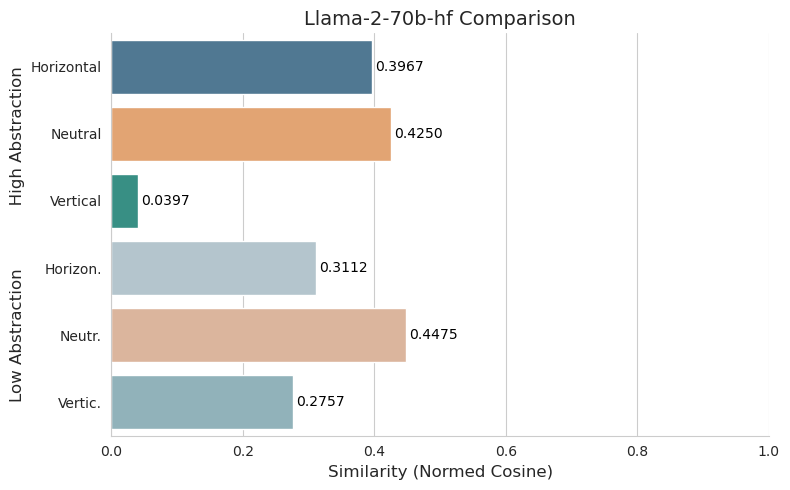

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

data = similarity_scores_constructs

# Set a custom color palette
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

# Create a horizontal bar plot using Seaborn
plt.figure(figsize=(8, 5))

sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=12)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=12)
plt.title(model_name+' Comparison', fontsize=14)

# Adding data values next to the bars
for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=10, color='black')

# Set x-axis limits
plt.xlim(0, 1)

# Remove spines (borders) from the plot
sns.despine()

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.show()


In [9]:
model_choices = dict()
with open("results/exp01a_"+model_name+".txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

model_choices

{'walked': [0, 0, 0, 1],
 'perched': [0, 1, 0, 0],
 'respected': [0, 1, 0, 0],
 'fled': [0, 0, 1, 0],
 'pulled': [0, 0, 1, 0],
 'wanted': [0, 0, 0, 1],
 'pushed': [0, 0, 1, 0],
 'argued with': [0, 0, 1, 0],
 'obeyed': [0, 0, 1, 0],
 'showed': [0, 0, 1, 0],
 'sank': [0, 1, 0, 0],
 'lifted': [0, 0, 1, 0],
 'regretted': [0, 0, 1, 0],
 'gave to': [0, 0, 1, 0],
 'pointed at': [0, 0, 1, 0],
 'impacted': [0, 0, 1, 0],
 'owned': [0, 0, 1, 0],
 'smashed': [0, 0, 0, 1],
 'increased': [0, 0, 1, 0],
 'floated': [0, 0, 0, 1],
 'bombed': [0, 0, 0, 1],
 'hunted': [0, 0, 0, 1],
 'tempted': [0, 0, 0, 1],
 'hoped': [0, 1, 0, 0],
 'rushed': [0, 0, 0, 1],
 'flew': [0, 0, 0, 1],
 'rested': [0, 0, 1, 0],
 'offended': [0, 0, 1, 0],
 'succeeded': [0, 0, 0, 1],
 'warned': [0, 0, 1, 0]}

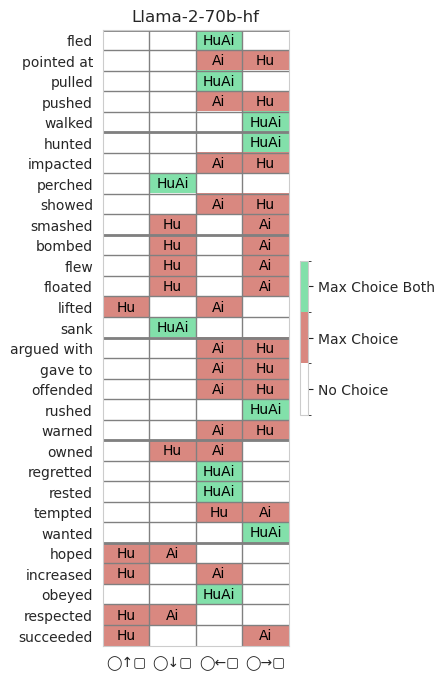

In [48]:
import matplotlib.pyplot as plt

# Example data (replace this with your actual dictionaries)
dict1 = richardson_categorial

dict2 = model_choices

# Create an empty matrix to store the sums
matrix = np.zeros((30, 4), dtype=int)

# Iterate through the keys in both dictionaries and calculate the sums
for i, key in enumerate(dict1.keys()):
    values1 = dict1[key]
    values2 = dict2[key]
    sum_values = [x + y for x, y in zip(values1, values2)]
    matrix[i] = sum_values


# Set up the color map for the plot
cmap = plt.cm.colors.ListedColormap(['white', '#D98880', '#82E0AA'])
bounds = [0, 1, 2, 3]  # Values correspond to colors: 0 (white), 1 (red), 2 (green)
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Create the plot and set the size
plt.figure(figsize=(3, 8))  # Adjust the size as needed

# Create the plot
plt.imshow(matrix, interpolation='nearest', cmap=cmap, norm=norm, aspect='auto')

# Set the row labels as the keys of the dictionaries
plt.yticks(np.arange(len(dict1)), dict1.keys())

# Set the column labels (optional)
plt.xticks(np.arange(4), ["◯↑▢","◯↓▢","◯←▢","◯→▢"])

plt.title(model_name)

# Add horizontal and vertical lines to create the grid between colored boxes
for i in range(matrix.shape[0] - 1):
    if i % 5 == 0:
        plt.hlines(i-1 + 0.5, -0.5, matrix.shape[1] - 0.5, color='grey', linewidth=2)

    plt.hlines(i + 0.5, -0.5, matrix.shape[1] - 0.5, color='grey', linewidth=1)

for j in range(matrix.shape[1] - 1):
    plt.vlines(j + 0.5, -0.5, matrix.shape[0] - 0.5, color='grey', linewidth=1)

# Remove minor ticks
plt.minorticks_off()

# Set gridlines to be invisible
plt.grid(False)

# Show the color bar
cbar = plt.colorbar(shrink=0.25) 
cbar.set_ticks([0.5, 1.5, 2.5])
cbar.set_ticklabels(['No Choice', 'Max Choice', 'Max Choice Both'])


# Add text annotations for custom labels "Hu" and "Ai"
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        value = matrix[i, j]
        if value == 1:
            if dict1[list(dict1.keys())[i]][j] == 1:
                plt.text(j, i, 'Hu', ha='center', va='center', fontsize=10, color='black')
            else:
                plt.text(j, i, 'Ai', ha='center', va='center', fontsize=10, color='black')
        elif value == 2:
            plt.text(j, i, 'HuAi', ha='center', va='center', fontsize=10, color='black')


# Display the plot
plt.show()
